# Fingerprint segmentation module

In [14]:
import numpy as np
import cv2 as cv
from utils import show
from ipywidgets import interact
import time
from IPython.display import clear_output
import json
import segmentation

In [15]:
# Paths
PATH_FVC = '../Datasets/'
PATH_PARAMS = '../parameters/segmentation/'
PATH_GT = '../Datasets/SegmentationBenchmark/GroundTruth/'
PATH_TESTS = '../test/'

## 1. Basic examples

Example: fingerprint segmentation using the default parameters.

,,
,,

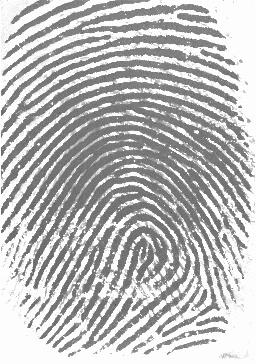
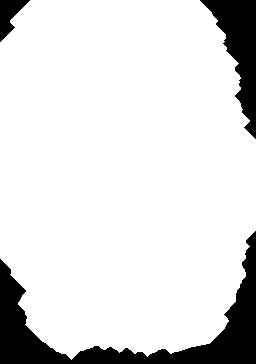
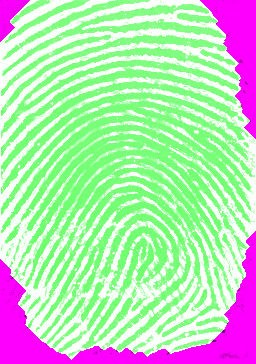

In [16]:
fingerprint = cv.imread(PATH_FVC + 'FVC2000/DB2_B/101_1.png', cv.IMREAD_GRAYSCALE)
mask = segmentation.run(fingerprint)
show(fingerprint, mask, cv.merge((fingerprint, mask, fingerprint)))

Example: segmentation with parameters loaded from file.

,,
,,

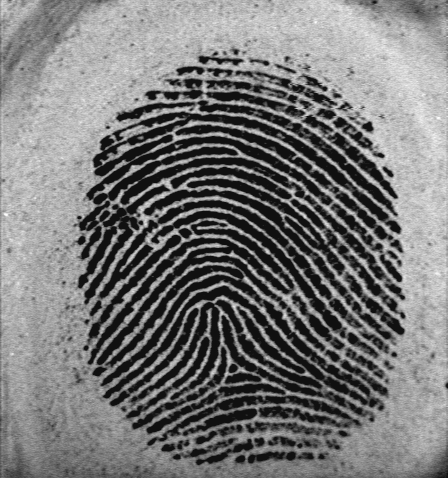
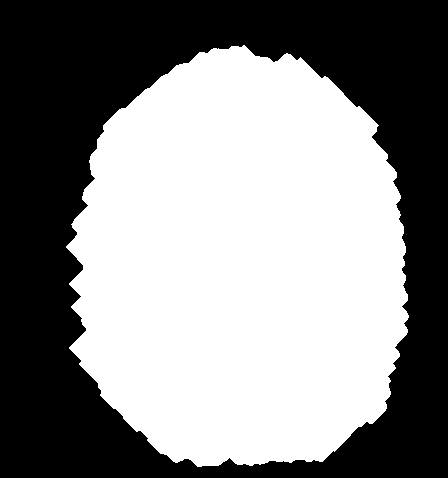
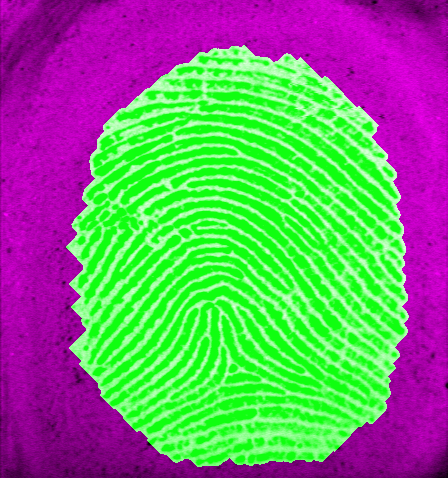

In [17]:
parameters = segmentation.load_parameters(PATH_PARAMS + 'FVC2000_DB3_B_best_params.txt')
fingerprint = cv.imread(PATH_FVC + 'FVC2000/DB3_B/101_1.png', cv.IMREAD_GRAYSCALE)
mask = segmentation.run(fingerprint, parameters)
show(fingerprint, mask, cv.merge((fingerprint, mask, fingerprint)))

Showing intermediate steps of the segmentation algorithm:

,Gradient magnitude,Sum over the window,Thresholding,After closing,Largest component,After fill holes,After opening,
,,,,,,,,

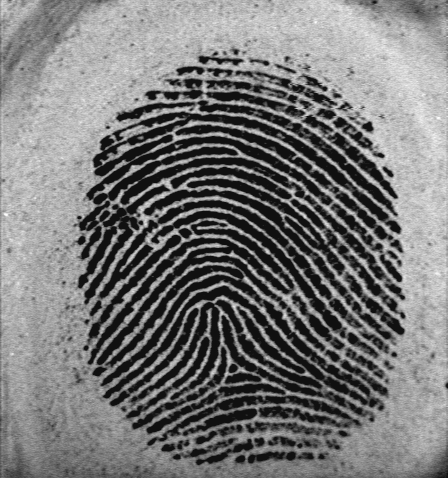
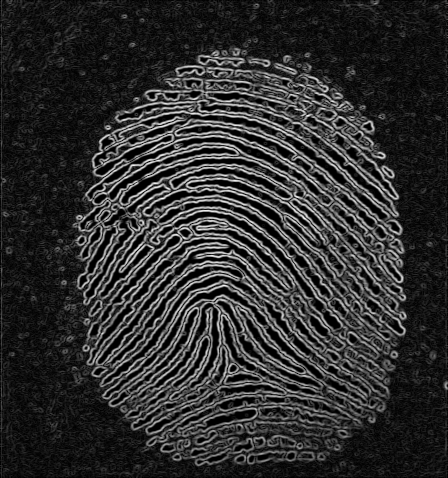
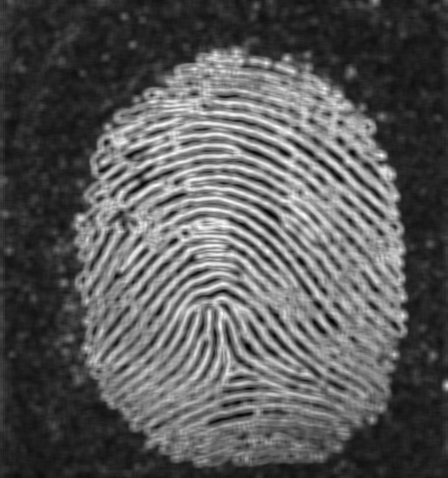
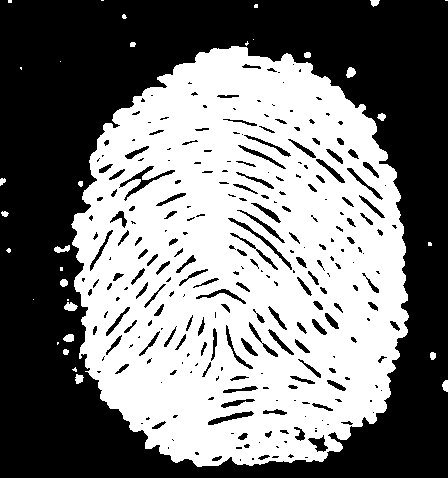
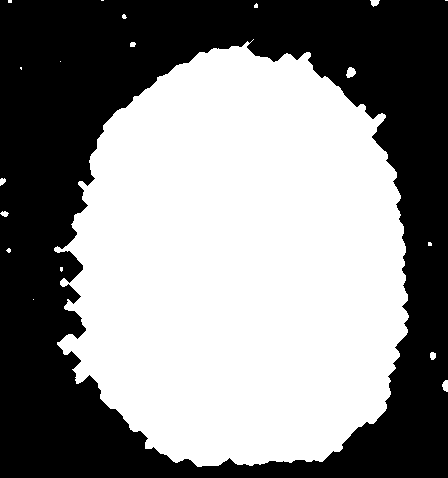
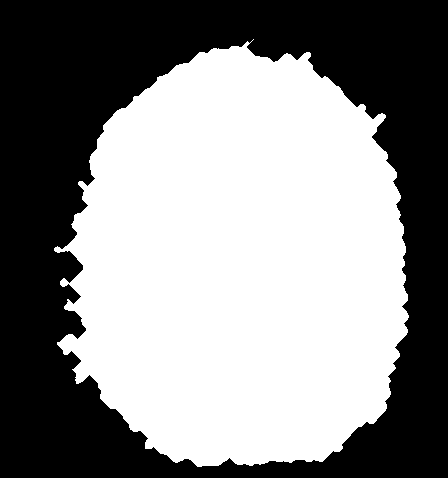
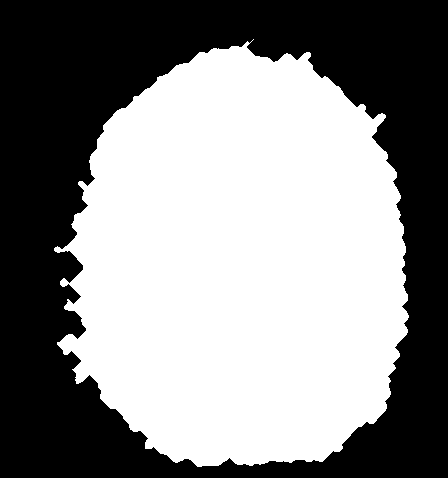
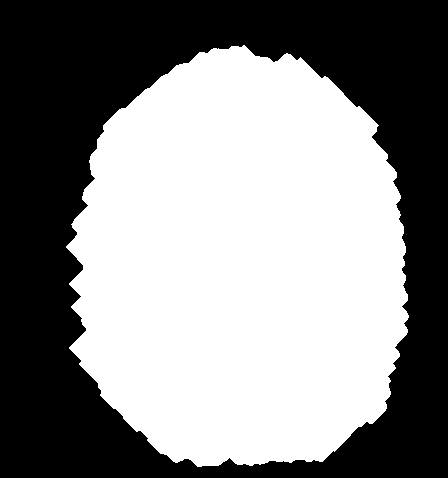
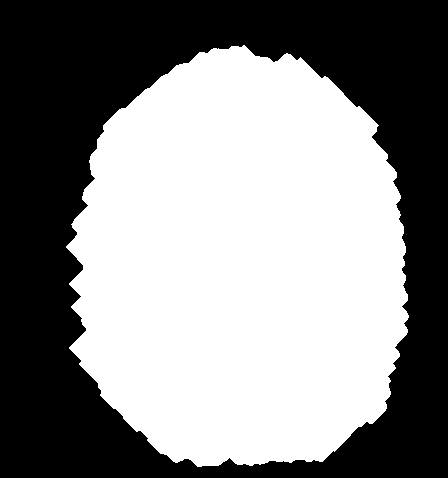

In [18]:
mask, intermediate_results = segmentation.run(fingerprint, parameters, True)
show(fingerprint, *intermediate_results, mask)

Testing the effect of the various parameters:

In [19]:
@interact(window_size=(3,21,2), percentile=(50, 100), threshold=(0,1,0.01), closing_count=(0,29), opening_count=(0,29) )
def test_parameters(window_size=parameters.window_size, percentile=parameters.percentile, 
                    threshold=parameters.threshold, closing_count=parameters.closing_count, 
                    opening_count=parameters.opening_count):
    p = segmentation.Parameters(window_size, percentile, threshold, closing_count, opening_count)
    mask, intermediate_results = segmentation.run(fingerprint, p, True)
    show(fingerprint, *intermediate_results, cv.merge((fingerprint, mask, fingerprint)), max_per_row=5)

interactive(children=(IntSlider(value=7, description='window_size', max=21, min=3, step=2), IntSlider(value=95…

## 2. Comparison with the groud truth

Comparing a segmentation result with the corresponding ground truth mask loaded from file.

,,,
,,,

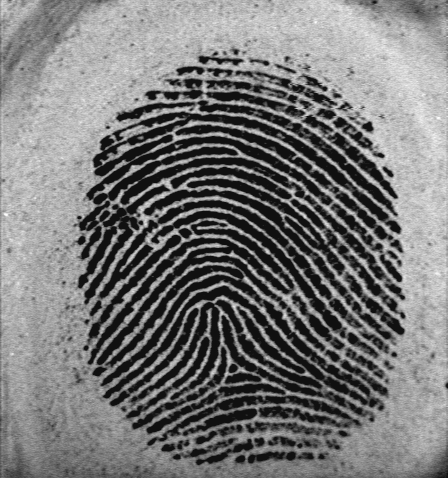
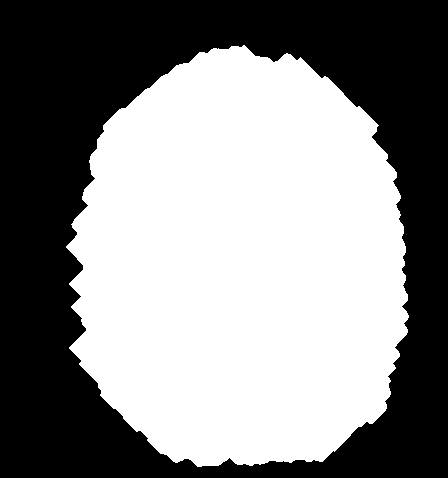
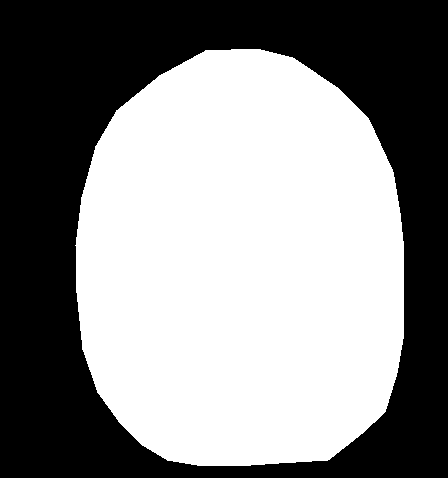
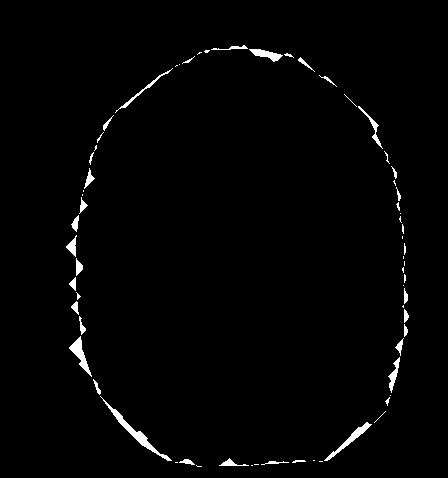

In [20]:
gt_mask = cv.bitwise_not(cv.imread(PATH_GT + 'FVC2000_DB3_IM_101_1seg.png', cv.IMREAD_GRAYSCALE))
show(fingerprint, mask, gt_mask, cv.bitwise_xor(mask, gt_mask))

For each fingerprint, the error is defined as the percentage of misclassified pixels with respect to the corresponding ground truth:

In [21]:
def segmentation_error(mask, gt_mask):
    return np.count_nonzero(gt_mask - mask) / mask.size * 100

print(f'Segmentation error of the previous example = {segmentation_error(mask, gt_mask):.2f}%')

Segmentation error of the previous example = 1.56%


The following code allows testing the segmentation algorithm on FVC2000/FVC2002/FVC2004 databases (sets "A"), using sets "B" for optimizing the parameters.

In [22]:
TRAIN_DATASETS = [(y, db, "B") for y in range(2000, 2006, 2) for db in range(1,5)]
TEST_DATASETS = [(y, db, "A") for y in range(2000, 2006, 2) for db in range(1,5)]

def load_db(year, db, subset):
    i1, i2 = (1, 100) if subset=="A" else (101, 110)
    j1, j2 = 1, 8
    return [(i, j, cv.imread(f'{PATH_FVC}FVC{year}/DB{db}_{subset}/{i}_{j}.png', cv.IMREAD_GRAYSCALE)) 
            for i in range(i1, i2+1) for j in range(j1, j2+1)]

def load_gt(year, db, subset):
    i1, i2 = (1, 100) if subset=="A" else (101, 110)
    j1, j2 = 1, 8
    return [cv.bitwise_not(cv.imread(f'{PATH_GT}/FVC{year}_DB{db}_IM_{i}_{j}seg.png', 
                                       cv.IMREAD_GRAYSCALE)) for i in range(i1, i2+1) for j in range(j1, j2+1)]

def segment_all_db(images, parameters):
    return [(i, j, segmentation.run(f, parameters)) for i, j, f in images]

def calculate_errors(masks, gt):
    results = [(i, j, segmentation_error(m, x)) for (i, j, m), x in zip(masks, gt)]
    errors = np.array([e for _, _, e in results])
    return errors, results

def average_err_on_db(images, gt, parameters):    
    return np.mean(calculate_errors(segment_all_db(images, parameters), gt)[0])

def run_test(year, db, subset, parameters):
    images = load_db(year, db, subset)
    gt = load_gt(year, db, subset)
    start = time.time()
    masks = segment_all_db(images, parameters)
    elapsed = time.time() - start
    errors, results = calculate_errors(masks, gt)
    avg_err = np.mean(errors)
    print(f'Test on FVC{year} DB{db}_{subset} ({len(images)} images). '\
          f'Error (avg/min/max) = {avg_err:5.2f}% / {errors.min():5.2f}% / {errors.max():5.2f}% '\
          f'Total time: {elapsed:5.2f} s Avg: {elapsed/len(images):.4f} s')
    
    with open(f'{PATH_TESTS}FVC{year}_DB{db}_{subset}_res.txt', 'w') as file:
        json.dump(results, file)
    
    return avg_err

In [23]:
def run_tests_with_best_parameters(year, db):
    parameters = segmentation.load_parameters(f'{PATH_PARAMS}FVC{year}_DB{db}_B_best_params.txt')
    return run_test(year, db, 'A', parameters)

Test on all sets "A" (12 databases, each containing 800 fingerprints) and calculates the average error over all the databases.

In [24]:
avg = np.mean(np.array([run_tests_with_best_parameters(y, db) for y, db, _ in TEST_DATASETS]))
print(f'Avg: {avg:.2f}%')

Test on FVC2000 DB1_A (800 images). Error (avg/min/max) =  4.71% /  1.20% / 29.25% Total time:  4.98 s Avg: 0.0062 s
Test on FVC2000 DB2_A (800 images). Error (avg/min/max) =  4.14% /  0.40% / 48.27% Total time:  4.55 s Avg: 0.0057 s
Test on FVC2000 DB3_A (800 images). Error (avg/min/max) =  3.73% /  0.62% / 59.84% Total time:  8.29 s Avg: 0.0104 s
Test on FVC2000 DB4_A (800 images). Error (avg/min/max) =  2.35% /  0.91% / 18.42% Total time:  4.17 s Avg: 0.0052 s
Test on FVC2002 DB1_A (800 images). Error (avg/min/max) =  1.99% /  0.62% / 11.87% Total time:  6.02 s Avg: 0.0075 s
Test on FVC2002 DB2_A (800 images). Error (avg/min/max) =  2.75% /  0.47% / 25.62% Total time:  6.15 s Avg: 0.0077 s
Test on FVC2002 DB3_A (800 images). Error (avg/min/max) =  4.12% /  0.90% / 30.25% Total time:  4.62 s Avg: 0.0058 s
Test on FVC2002 DB4_A (800 images). Error (avg/min/max) =  4.08% /  0.83% / 23.54% Total time:  4.82 s Avg: 0.0060 s
Test on FVC2004 DB1_A (800 images). Error (avg/min/max) =  1.09%

Error analysis: for each databases, fingerprints are sorted according to the error rate in the previous test.

In [ ]:
@interact(year=[2000,2002,2004], db=[1,2,3,4])
def choose_db(year, db):
    subset = 'A'
    with open(f'{PATH_TESTS}FVC{year}_DB{db}_{subset}_res.txt', 'r') as filehandle:
        results = json.load(filehandle)

    results = sorted(results, key=lambda r: r[2])
    parameters = segmentation.load_parameters(f'{PATH_PARAMS}FVC{year}_DB{db}_B_best_params.txt')
    
    @interact(i=(0, len(results)-1))
    def show_result(i=0):
        i, j, err = results[i]
        img = cv.imread(f'{PATH_FVC}FVC{year}/DB{db}_{subset}/{i}_{j}.png', cv.IMREAD_GRAYSCALE)
        gt = cv.bitwise_not(cv.imread(f'{PATH_GT}FVC{year}_DB{db}_IM_{i}_{j}seg.png', cv.IMREAD_GRAYSCALE))
        mask = segmentation.run(img, parameters)
        v_mask = cv.merge((gt, mask, cv.bitwise_not(img)))
        show((img,f'{i}_{j}'), (mask, 'Result'), (gt, 'Ground truth'), (v_mask, f'Error = {err:.2f}%'))

## 3. Parameter optimization

Optimizazion of the parameters on each FVC database set "B":

In [ ]:
def optimize_parameters_in_ranges(year, db, subset, images, gt, best_parameters, ranges):    
    min_err = 100 if best_parameters is None else average_err_on_db(images, gt, best_parameters)
    for w in ranges[0]:
        for p in ranges[1]:  
            for t in ranges[2]:
                for cc in ranges[3]:
                    for oc in ranges[4]:
                        parameters = segmentation.Parameters(w, p, t, cc, oc)
                        e = average_err_on_db(images, gt, parameters)                
                        if e < min_err:
                            min_err = e
                            best_parameters = parameters
                            # saves best parameters to file
                            best_parameters.save(f'../test/FVC{year}_DB{db}_{subset}_params.txt')
                        print(f'{year}-{db}-{subset}: {len(images)} fingerprints')
                        print(f'{parameters}\n-> {e:.2f}%\n(best: {best_parameters}\n-> {min_err:.2f}%)')
                        clear_output(True)
    return best_parameters

def optimize_parameters(year, db, subset):
    images = load_db(year, db, subset)
    gt = load_gt(year, db, subset)
    p = None
    try:
        p = segmentation.load_parameters(f'{PATH_TESTS}FVC{year}_DB{db}_B_params.txt')
        print(f'Loaded best parameters: {p}')
    except:
        print('Best parameters not found')
    p = optimize_parameters_in_ranges(year, db, subset, images, gt, p,
                                      [
                                          range(3,19,2),
                                          [85,90,95],
                                          [0.15,0.20,0.25,0.30],
                                          [7],
                                          [13],
                                      ])
    p = optimize_parameters_in_ranges(year, db, subset, images, gt, p,
                                      [
                                          [p.window_size],
                                          range(75,100,5),
                                          np.arange(0.05,0.4,0.01),
                                          [7],
                                          [13],
                                      ])
    p = optimize_parameters_in_ranges(year, db, subset, images, gt, p,
                                      [
                                          [p.window_size],
                                          [p.percentile],
                                          [p.threshold],
                                          range(0,15,3),
                                          range(0,24,3),
                                      ])

In [ ]:
for y, db, subset in TRAIN_DATASETS:
    optimize_parameters(y, db, subset)